49
G Graph with 49 nodes and 1176 edges
T Graph with 49 nodes and 48 edges
C1 [(0, 1, 2.0), (1, 2, 2.0), (2, 3, 2.0), (3, 0, 6.0)]
C2 [(1, 2, 2.0), (2, 3, 2.0)]
P1 [(3, 2, 2.0), (2, 1, 2.0), (1, 0, 2.0)]
A MultiGraph with 49 nodes and 48 edges
A_odd Graph with 0 nodes and 0 edges
M set()
K MultiGraph with 49 nodes and 48 edges
P2 [(0, 1, 2.0)]
K MultiGraph with 49 nodes and 48 edges


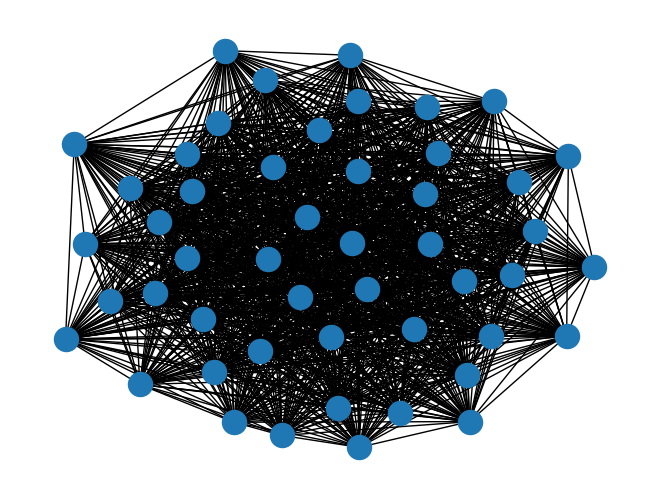

[Circle(0, 0, r=1), Circle(0, 2, r=1), Circle(0, 4, r=1), Circle(0, 6, r=1), Circle(0, 8, r=1), Circle(0, 10, r=1), Circle(0, 12, r=1), Circle(2, 0, r=1), Circle(2, 2, r=1), Circle(2, 4, r=1), Circle(2, 6, r=1), Circle(2, 8, r=1), Circle(2, 10, r=1), Circle(2, 12, r=1), Circle(4, 0, r=1), Circle(4, 2, r=1), Circle(4, 4, r=1), Circle(4, 6, r=1), Circle(4, 8, r=1), Circle(4, 10, r=1), Circle(4, 12, r=1), Circle(6, 0, r=1), Circle(6, 2, r=1), Circle(6, 4, r=1), Circle(6, 6, r=1), Circle(6, 8, r=1), Circle(6, 10, r=1), Circle(6, 12, r=1), Circle(8, 0, r=1), Circle(8, 2, r=1), Circle(8, 4, r=1), Circle(8, 6, r=1), Circle(8, 8, r=1), Circle(8, 10, r=1), Circle(8, 12, r=1), Circle(10, 0, r=1), Circle(10, 2, r=1), Circle(10, 4, r=1), Circle(10, 6, r=1), Circle(10, 8, r=1), Circle(10, 10, r=1), Circle(10, 12, r=1), Circle(12, 0, r=1), Circle(12, 2, r=1), Circle(12, 4, r=1), Circle(12, 6, r=1), Circle(12, 8, r=1), Circle(12, 10, r=1), Circle(12, 12, r=1)]


In [22]:
import typing
import math
from cetsp.common import Circle
import networkx as nx
import matplotlib.pyplot as plt

def dist(p0: Circle, p1: Circle) -> float:
    return math.sqrt((p0.x - p1.x) ** 2 + (p0.y - p1.y) ** 2)

def create_graph(instance):
    G = nx.Graph()
    for u_idx, u in enumerate(instance):
        G.add_node(u_idx)
        for v_idx, v in enumerate(instance[:u_idx]):
            G.add_edge(u_idx, v_idx, weight=dist(u, v))
    return G

def tsp_lower_bound(instance: typing.List[Circle]):
    # TODO use real TSP solver
    G = create_graph(instance)
    T = nx.minimum_spanning_tree(G)
    return G.size(weight="weight")

def tsp_with_partial_order_lower_bound(instance: typing.List[Circle], partial_order: typing.List[int]):
    # If the given order size is <= 3, we can ignore it
    if len(partial_order) <= 3:
        return tsp_lower_bound(instance)

    # 1: Compute a minimum spanning tree T in G
    G = create_graph(instance)
    T = nx.minimum_spanning_tree(G)

    # 2: C := s1 s2 . . . sk s1
    # 3: Let e1 and e2 be the two most expensive edges of C and let C′ := C − e1 − e2
    C1 = []
    for u in partial_order:
        v = partial_order[(u + 1) % len(partial_order)]
        C1.append((u, v, G[u][v]["weight"]))
    C2 = C1.copy()
    e1 = max(C2, key=lambda e: e[2])
    C2.remove(e1)
    e2 = max(C2, key=lambda e: e[2])
    C2.remove(e2)

    # 4: Let P be the path in T connecting the vertices that are incident to e1
    P1 = nx.shortest_path(T, source=e1[0], target=e1[1])
    P1 = [(u, v, G[u][v]["weight"]) for (u, v) in zip(P1, P1[1:])]

    # 5: Compute a minimum perfect matching M on the odd vertices in the multigraph A := T ∪ C′
    A = nx.MultiGraph(T)
    for e in C2:
        G.add_edge(e[0], e[1], weight=e[2])
    A_odd = nx.Graph()
    for u in G.nodes():
        if G.degree[u] % 2 == 1:
            A_odd.add_node(u)
            for v in A_odd.nodes():
                if u != v:
                    A_odd.add_edge(u, v, weight=G[u][v]["weight"])
    M = nx.min_weight_matching(A_odd)
    assert nx.is_perfect_matching(A_odd, M)

    # 6: Let P′ be the path in A ∪ M \ (C′ ∪ P ) connecting the vertices that are incident to e2
    K = nx.MultiGraph(A)
    K.add_weighted_edges_from(M)
    K.remove_edges_from(C2)
    K.remove_edges_from(P1)
    P2 = nx.shortest_path(K, source=e2[0], target=e2[1])
    P2 = [(u, v, G[u][v]["weight"]) for (u, v) in zip(P2, P2[1:])]

    # 7: Starting from the circuit C′ ∪ P ∪ P′, compute an Eulerian tour in A ∪ M that respects the order of t
    K.remove_edges_from(P2)
    cc = list(nx.connected_components(K))
    vertex_to_cc = [None] * K.number_of_nodes()
    for c_idx, c in enumerate(cc):
        for u in c:
            assert vertex_to_cc[u] is None
            vertex_to_cc[u] = c_idx
    for c in cc:
        g = K.subgraph(c)
        if nx.is_eulerian(g):
            continue
        nx.draw(G)
        plt.show()
        return 0
        
    cc_tours = [list(nx.eulerian_circuit(K.subgraph(c))) for c in cc]
    # Create an initial tour of C′ ∪ P ∪ P′
    tour = []
    for e in C1:
        if e == e1:
            tour += P1
        elif e == e2:
            tour += P2
        else:
            tour.append(e)
    # Construct the full tour by iterating over the initial tour and inserting each individual component's Eulerian tour
    full_tour = []
    is_c_added = [False] * len(cc)
    for e in tour:
        u, v, _d = e
        full_tour.append(e)
        c_idx = vertex_to_cc[v]
        if c_idx is None or is_c_added[c_idx]:
            continue
        # find v in its component Eulerian tour
        c_tour = cc_tours[c_idx]
        v_idx = None
        for w_idx, (w, _) in enumerate(c_tour):
            if w == v:
                v_idx = w_idx
                break
        full_tour += c_tour[w_idx:] + c_tour[:w_idx]
        is_c_added[c_idx] = True

    # 8: Shorten the Eulerian tour to a Hamiltonian tour respecting the order of t.
    visited = [False] * G.number_of_nodes()
    source = full_tour[0]
    tour = [source]
    visited[source] = True
    assert source == partial_order[0]
    is_in_partial_order = [False] * G.number_of_nodes()
    for v in partial_order:
        is_in_partial_order[v] = True
    idx_in_partial_order = 1
    for e in full_tour:
        v = e[1]
        if visited[v]:
            continue # skip visited vertices
        next_in_partial_order = None if idx_in_partial_order >= len(partial_order) else partial_order[idx_in_partial_order]
        if is_in_partial_order[v] and v != next_in_partial_order:
            continue # maintain the order, will be visited later
        tour.append(v)
        visited[v] = True
        if is_in_partial_order[v]:
            idx_in_partial_order += 1
    assert all(visited)
    tour = full_tour

    # Calculate the tour weight
    weight = 0
    for i in range(tour):
        u, v = tour[i], tour[(i+1) % len(tour)]
        weight += G[u][v]["weight"]
    
    # Calc lower bound
    weight /= (2.5-2/len(partial_order))
    weight -= sum((c.radius for c in instance))
    return max(weight, 0)

instance = [
    Circle(2*x, 2*y, 1) for x in range(7) for y in range(7)
]
partial_order = [0,1,2,3]
lower_bound = tsp_with_partial_order_lower_bound(instance, partial_order)
print(lower_bound)